## Persiapan

### Menyiapkan library yang dibutuhkan

In [ ]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error, r2_score, classification_report, confusion_matrix
)

### Menyiapkan data yang akan diguankan

In [ ]:
# Load Data
df = pd.read_csv("flood.csv")

## Data Understanding

### Analisis informasi umum (jumlah data, tipe data, nilai null, duplikat)

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MonsoonIntensity                 50000 non-null  int64  
 1   TopographyDrainage               50000 non-null  int64  
 2   RiverManagement                  50000 non-null  int64  
 3   Deforestation                    50000 non-null  int64  
 4   Urbanization                     50000 non-null  int64  
 5   ClimateChange                    50000 non-null  int64  
 6   DamsQuality                      50000 non-null  int64  
 7   Siltation                        50000 non-null  int64  
 8   AgriculturalPractices            50000 non-null  int64  
 9   Encroachments                    50000 non-null  int64  
 10  IneffectiveDisasterPreparedness  50000 non-null  int64  
 11  DrainageSystems                  50000 non-null  int64  
 12  CoastalVulnerabili

In [ ]:
print("\nJumlah missing values per kolom:\n", df.isnull().sum())


Jumlah missing values per kolom:
 MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64


In [ ]:
# Mengecek dataset menggunakan duplicated().sum()
print(df.duplicated().sum())

0


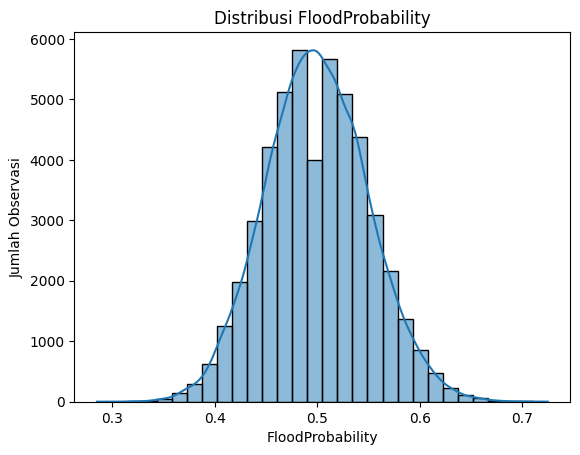

In [ ]:
# Distribusi FloodProbability
sns.histplot(df['FloodProbability'], bins=30, kde=True)
plt.title("Distribusi FloodProbability")
plt.xlabel("FloodProbability")
plt.ylabel("Jumlah Observasi")
plt.show()

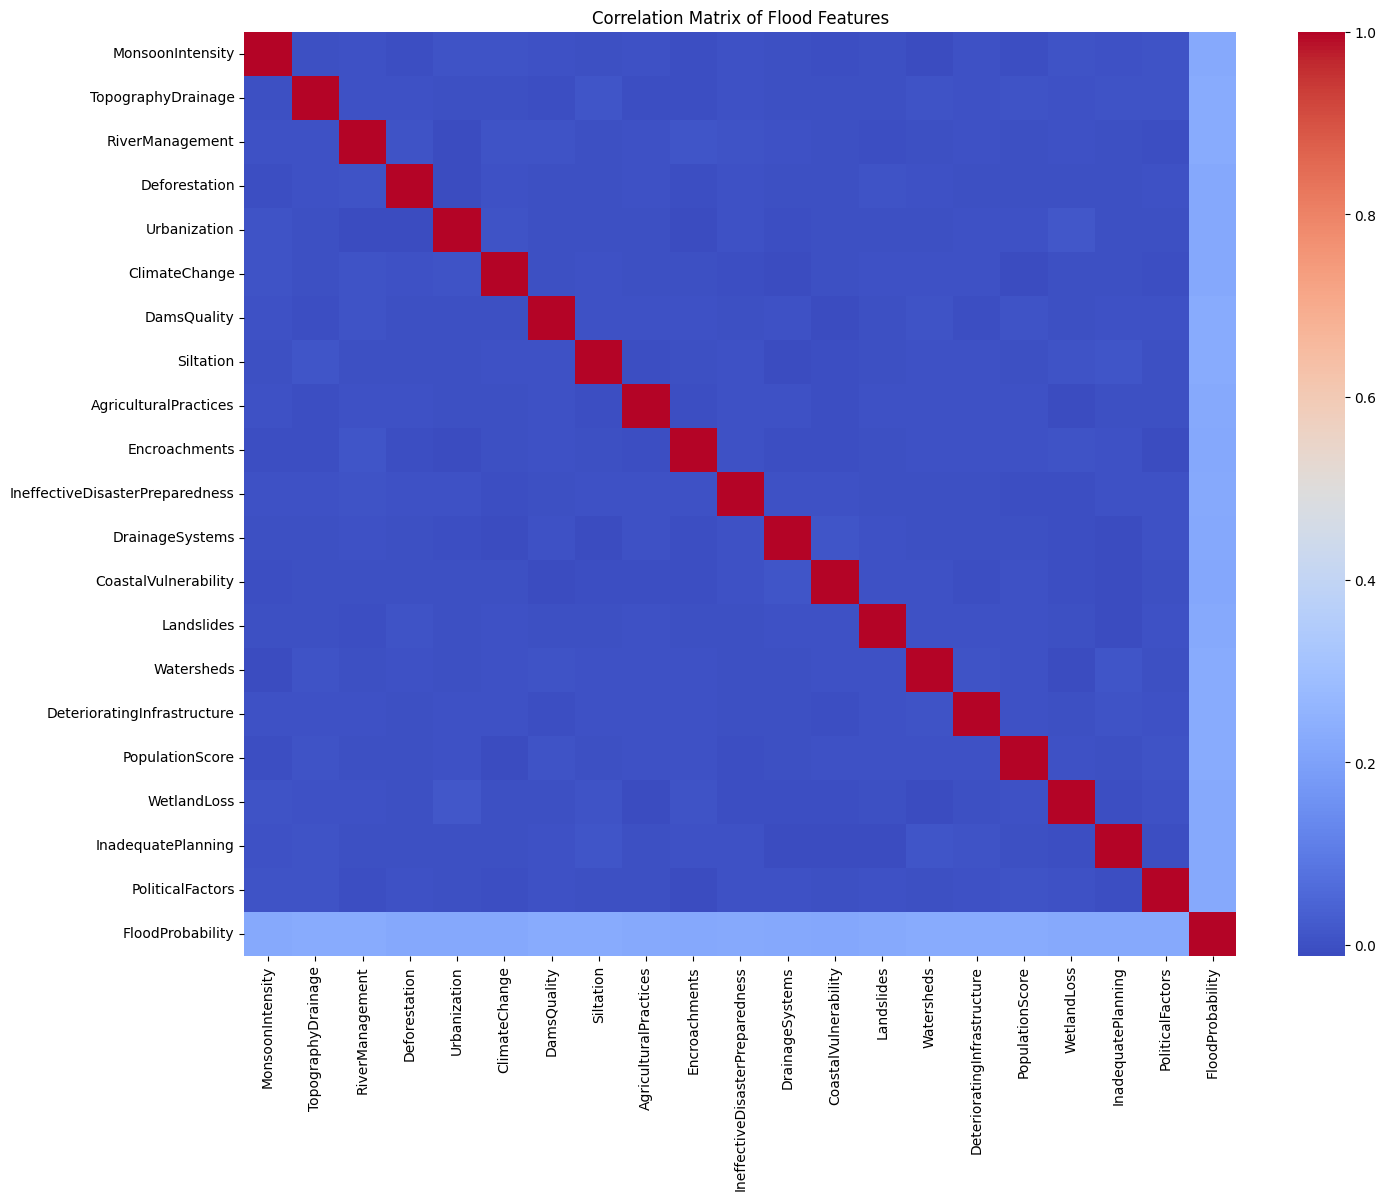

In [ ]:
# Korelasi Antar Fitur
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Matrix of Flood Features")
plt.show()

### Hasil korelasi matirix menunjukan hubungan korelasi tinggi secara kolektif `FloodProbability`, Mari uji dengan regresi linier untuk melihat apakah `FloodProbability` adalah kombinasi linier dari fitur lainnya.

RMSE (all data): 0.0000000000
R² Score (all data): 1.0000000000


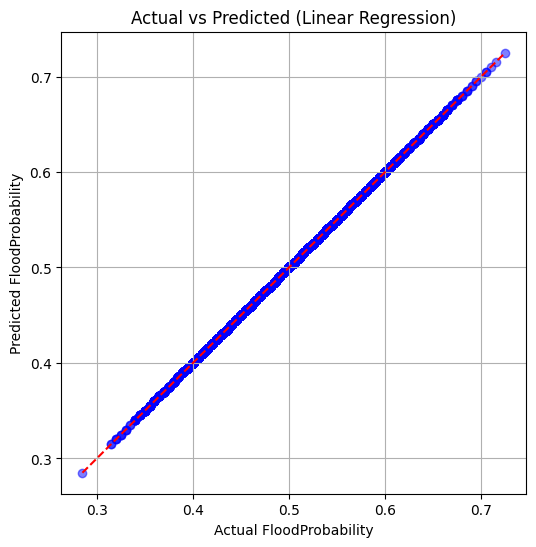

In [ ]:
# Cek Linearitas FloodProbability
X_all = df.drop("FloodProbability", axis=1)
y_all = df["FloodProbability"]

lr_check = LinearRegression()
lr_check.fit(X_all, y_all)

y_pred_all = lr_check.predict(X_all)
rmse_all = np.sqrt(mean_squared_error(y_all, y_pred_all))
r2_all = r2_score(y_all, y_pred_all)

print(f"RMSE (all data): {rmse_all:.10f}")
print(f"R² Score (all data): {r2_all:.10f}")

# 🔍 Visualisasi Prediksi vs Aktual
plt.figure(figsize=(6,6))
plt.scatter(y_all, y_pred_all, alpha=0.5, color='blue')
plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], 'r--')
plt.xlabel("Actual FloodProbability")
plt.ylabel("Predicted FloodProbability")
plt.title("Actual vs Predicted (Linear Regression)")
plt.grid(True)
plt.show()

## Data Preparation

### `FloodProbability` dapat **dibinning** menjadi kelas risiko (`FloodRiskLevel`) menggunakan teknik Quantile Binning, untuk menyeimbangkan distribusi label

In [ ]:
# Klasifikasi Risiko: Quantile Binning
df['FloodRiskLevel'] = pd.qcut(df['FloodProbability'],
                                q=3,
                                labels=['Low', 'Medium', 'High'])

/tmp/ipykernel_7179/643262077.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='FloodRiskLevel', data=df, order=['Low', 'Medium', 'High'], palette='viridis')


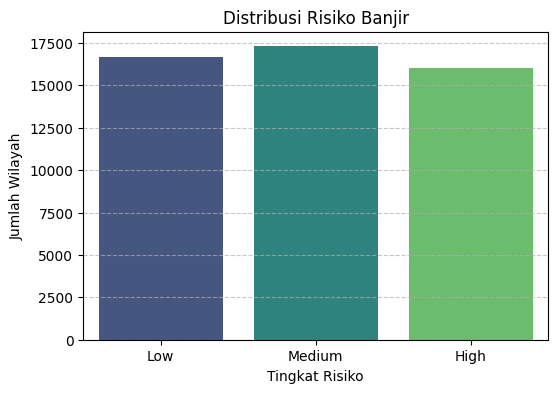

In [ ]:
# Distribusi Kategori
plt.figure(figsize=(6,4))
sns.countplot(x='FloodRiskLevel', data=df, order=['Low', 'Medium', 'High'], palette='viridis')
plt.title("Distribusi Risiko Banjir")
plt.xlabel("Tingkat Risiko")
plt.ylabel("Jumlah Wilayah")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Persiapan Fitur dan Target
X = df.drop(['FloodProbability', 'FloodRiskLevel'], axis=1)
y = df['FloodRiskLevel']

# 🔤 Encode Label
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ✂️ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

## Modeling

In [ ]:
# Logistic Regression
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
y_pred_lr = lr_clf.predict(X_test)

# 🌲 Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

## Evaluation

In [ ]:
# Evaluasi Model
def evaluate_classification(y_true, y_pred, model_name):
    print(f"📌 Evaluation: {model_name}")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print("-" * 50)

📌 Evaluation: Logistic Regression
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      4845
         Low       1.00      1.00      1.00      4941
      Medium       1.00      1.00      1.00      5214

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



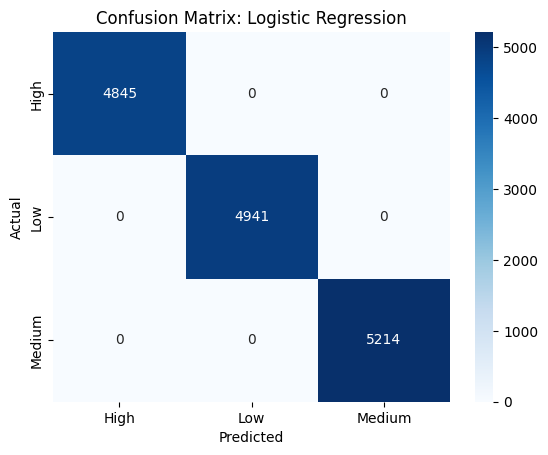

--------------------------------------------------


In [ ]:
# Evaluasi model Logistic Regression
evaluate_classification(y_test, y_pred_lr, "Logistic Regression")

📌 Evaluation: Random Forest Classifier
              precision    recall  f1-score   support

        High       0.85      0.78      0.82      4845
         Low       0.80      0.86      0.83      4941
      Medium       0.67      0.67      0.67      5214

    accuracy                           0.77     15000
   macro avg       0.77      0.77      0.77     15000
weighted avg       0.77      0.77      0.77     15000



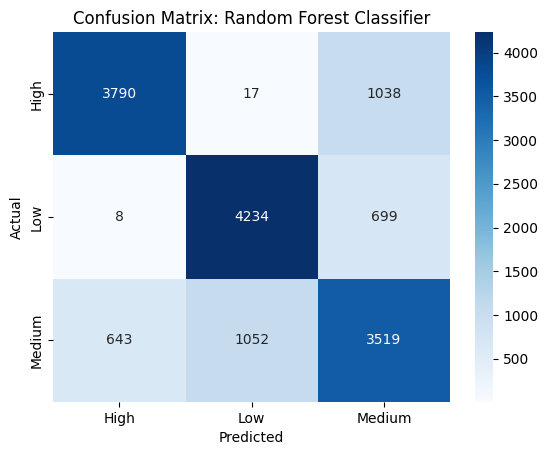

--------------------------------------------------


In [ ]:
# Evaluasi model Random Forest Classifier
evaluate_classification(y_test, y_pred_rf, "Random Forest Classifier")